<a href="https://colab.research.google.com/github/jaison-leonardo/projects-ML-DL-iue/blob/main/Generate_poetry_spanish.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generador de Poesía en Español con LSTM y Rima Forzada

Se implementa paso a paso un generador de poesía en español usando una red LSTM en PyTorch, forzando esquemas de rima (AABB, ABAB, etc).

Dataset obtenido de: https://huggingface.co/datasets/somosnlp-hackathon-2022/spanish-poetry-dataset

---


## 1. ¿Cómo funciona?

**Tokenización y Vocabulario:**
- Cada verso se divide en palabras (tokens). Se construye un vocabulario con las palabras más frecuentes y se asignan índices.
- Palabras poco frecuentes se reemplazan por `<unk>`.

**Rima forzada:**
- Para cada palabra, se extrae un sufijo (por ejemplo, las últimas 3 letras).
- Se asigna una etiqueta de rima (A, B, C...) a cada sufijo frecuente.
- Al generar, la última palabra de cada verso se fuerza a tener el sufijo correspondiente al esquema de rima (AABB, ABAB, etc).

**Modelo LSTM:**
- Una red LSTM aprende a predecir la siguiente palabra dado el contexto de palabras anteriores.
- El modelo tiene una capa de embedding, una LSTM y una capa lineal final.

**Entrenamiento:**
- Se entrena para predecir la siguiente palabra de cada verso (teacher forcing).
- Se usa CrossEntropyLoss ignorando el padding.

**Generación:**
- Se genera verso a verso, palabra a palabra.
- Para la última palabra de cada verso, se filtra el vocabulario para que solo se puedan elegir palabras con el sufijo de rima correcto.
- Si no hay candidatos, se relaja la restricción usando top-k sampling.

---


In [1]:
# 2. Instalación de dependencias
!pip install torch numpy pandas tqdm


## 3. Subir el archivo poems.csv

Sube tu archivo `poems.csv` (debe tener columnas como `author`, `content`, `title`). El script detectará automáticamente la columna con más texto útil.


In [2]:
from google.colab import files
uploaded = files.upload()
# El archivo debe llamarse poems.csv o renómbralo aquí si es necesario
import os
if 'poems.csv' not in uploaded:
    for k in uploaded:
        os.rename(k, 'poems.csv')
        break
print('Archivos en el directorio actual:')
!ls -l


Saving poems.csv to poems (1).csv
Archivos en el directorio actual:
total 5084
-rw-r--r-- 1 root root 5198384 Oct 29 05:17 poems.csv
drwxr-xr-x 1 root root    4096 Oct 27 13:37 sample_data


## 4. Preprocesado, tokenización y construcción de vocabulario

- Leemos el CSV y detectamos automáticamente la columna con más texto útil.
- Cada poema se separa en versos (líneas), preservando saltos de estrofa.
- Se normaliza a minúsculas y se eliminan espacios extra.
- Se tokeniza por palabra (split por espacio).
- Se construye un vocabulario con las palabras más frecuentes (parámetro `max_vocab`).
- Palabras fuera del vocabulario se reemplazan por `<unk>`.
- Se asignan sufijos de rima y etiquetas (A, B, C...) según frecuencia.


In [9]:
import pandas as pd
import numpy as np
import re
from collections import Counter

# Parámetros
max_vocab = 20000  # Se intenta reducir los <unk>
rhyme_suffix_len = 3
special_tokens = ['<pad>', '<s>', '</s>', '<unk>']

# Leer CSV y detectar columna de texto
poems_df = pd.read_csv('poems.csv', encoding='utf-8')
def detect_text_column(df):
    text_cols = []
    for c in df.columns:
        if df[c].dtype == object:
            total = df[c].dropna().astype(str).map(len).sum()
            text_cols.append((total, c))
    text_cols.sort(reverse=True)
    return text_cols[0][1]

text_col = detect_text_column(poems_df)
print('Columna de texto detectada:', text_col)

# Extraer versos y limpiar
verses = []
def clean_line(line):
    if line is None:
        return ''
    line = str(line).replace('\ufeff', '').replace('\r', '').strip().lower()
    line = re.sub(r"\s+", ' ', line)
    return line

def lines_from_text_block(text_block):
    text_block = str(text_block).replace('\r\n', '\n').replace('\r', '\n')
    lines = [clean_line(l) for l in text_block.split('\n')]
    return lines

for v in poems_df[text_col].astype(str).fillna(''):
    block_lines = lines_from_text_block(v)
    for l in block_lines:
        if l == '':
            verses.append('')
        else:
            verses.append(l)

print('Número total de versos (incluyendo líneas vacías):', len(verses))

# Tokenización y vocabulario
words = []
for l in verses:
    if l:
        words.extend(l.split())
word_freq = Counter(words)
most = [w for w, _ in word_freq.most_common(max_vocab)]
token_to_idx = {tok: i for i, tok in enumerate(special_tokens)}
for w in most:
    if w not in token_to_idx:
        token_to_idx[w] = len(token_to_idx)
idx_to_token = {i: t for t, i in token_to_idx.items()}
print('Tamaño del vocabulario:', len(token_to_idx))

# Sufijos de rima y etiquetas
def get_rhyme_suffix(word, rhyme_suffix_len=3):
    w = re.sub(r"[^\wáéíóúüñÁÉÍÓÚÜÑ]", '', word, flags=re.UNICODE).lower()
    return w[-rhyme_suffix_len:] if len(w) >= rhyme_suffix_len else w

suffix_counts = Counter()
word_suffix = {}
for w in most:
    s = get_rhyme_suffix(w, rhyme_suffix_len)
    word_suffix[w] = s
    suffix_counts[s] += 1
label_map = {}
for i, (suf, _) in enumerate(suffix_counts.most_common()):
    label = chr(ord('A') + (i % 26))
    label_map[suf] = label
word2label = {w: label_map[word_suffix[w]] for w in most}
print('Ejemplo de sufijos y etiquetas de rima:', list(label_map.items())[:10])


Columna de texto detectada: content
Número total de versos (incluyendo líneas vacías): 173016
Tamaño del vocabulario: 20004
Ejemplo de sufijos y etiquetas de rima: [('ndo', 'A'), ('ado', 'B'), ('nte', 'C'), ('ada', 'D'), ('dos', 'E'), ('ido', 'F'), ('ras', 'G'), ('res', 'H'), ('das', 'I'), ('les', 'J')]


In [10]:
# Diagnóstico: muestra versos originales y su tokenización
print('\nEjemplo de versos originales y tokens:')
for i, l in enumerate(verses):
    if l and i < 10:
        print(f"Verso: {l}")
        print(f"Tokens: {l.split()}")
        print()


Ejemplo de versos originales y tokens:
Verso: en el parque confuso
Tokens: ['en', 'el', 'parque', 'confuso']

Verso: que con lánguidas brisas el cielo sahúma,
Tokens: ['que', 'con', 'lánguidas', 'brisas', 'el', 'cielo', 'sahúma,']

Verso: el ciprés, como un huso,
Tokens: ['el', 'ciprés,', 'como', 'un', 'huso,']

Verso: devana un ovillo de de bruma.
Tokens: ['devana', 'un', 'ovillo', 'de', 'de', 'bruma.']

Verso: el telar de la luna tiende en plata su urdimbre;
Tokens: ['el', 'telar', 'de', 'la', 'luna', 'tiende', 'en', 'plata', 'su', 'urdimbre;']

Verso: abandona la rada un lúgubre corsario,
Tokens: ['abandona', 'la', 'rada', 'un', 'lúgubre', 'corsario,']

Verso: y después suena un timbre
Tokens: ['y', 'después', 'suena', 'un', 'timbre']

Verso: en el vecindario.
Tokens: ['en', 'el', 'vecindario.']



## 5. Definición del modelo LSTM

- El modelo tiene una capa de embedding, una LSTM y una capa lineal final.
- La entrada es una secuencia de índices de palabras.
- La salida es una secuencia de logits (probabilidades no normalizadas) para cada posición.


In [11]:
import torch
import torch.nn as nn

class PoetryLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_size=256, num_layers=1, dropout=0.2, pad_idx=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embed_dim, hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, vocab_size)
    def forward(self, x, hidden=None):
        emb = self.embedding(x)
        out, hidden = self.lstm(emb, hidden)
        logits = self.fc(out)
        return logits, hidden

vocab_size = len(token_to_idx)
pad_idx = token_to_idx['<pad>']
model = PoetryLSTM(vocab_size, pad_idx=pad_idx)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(model)


PoetryLSTM(
  (embedding): Embedding(20004, 128, padding_idx=0)
  (lstm): LSTM(128, 256, batch_first=True, dropout=0.2)
  (fc): Linear(in_features=256, out_features=20004, bias=True)
)


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


## 6. Preparación de datos para entrenamiento

- Cada verso se convierte en una secuencia de índices de palabras, con tokens especiales `<s>` (inicio) y `</s>` (fin).
- Se ignoran líneas vacías (separadores de estrofa).
- Se rellenan las secuencias con `<pad>` para igualar longitudes en cada batch.


In [12]:
from torch.utils.data import Dataset, DataLoader

class VersesDataset(Dataset):
    def __init__(self, verses, token_to_idx):
        self.sequences = []
        for l in verses:
            if not l:
                continue
            toks = ['<s>'] + l.split() + ['</s>']
            idxs = [token_to_idx.get(t, token_to_idx['<unk>']) for t in toks]
            self.sequences.append(idxs)
    def __len__(self):
        return len(self.sequences)
    def __getitem__(self, idx):
        return torch.tensor(self.sequences[idx], dtype=torch.long)

def collate_fn(batch):
    lengths = [b.size(0) for b in batch]
    maxlen = max(lengths)
    padded = torch.full((len(batch), maxlen), fill_value=pad_idx, dtype=torch.long)
    for i, b in enumerate(batch):
        padded[i, : b.size(0)] = b
    return padded

dataset = VersesDataset(verses, token_to_idx)
print('Número de versos para entrenamiento:', len(dataset))


Número de versos para entrenamiento: 150424


## 7. Entrenamiento del modelo, visualización de la pérdida y generación de ejemplos

- Entrenamos el modelo usando CrossEntropyLoss ignorando el padding.
- Se usa Adam como optimizador.
- Al final de cada epoch, se grafica la pérdida y se genera un ejemplo de estrofa con rima forzada para monitoreo.


Epoch 1: 100%|██████████| 2351/2351 [00:40<00:00, 57.70it/s]


Epoch 1 - Loss promedio: 3.8025

Ejemplo de estrofa generada (AABB):
de mí el corazón de <unk>
tu corazón, de <unk> era la <unk>
y la voz de <unk> viene!
que no quiero,
----------------------------------------


Epoch 2: 100%|██████████| 2351/2351 [00:41<00:00, 56.65it/s]


Epoch 2 - Loss promedio: 3.6090

Ejemplo de estrofa generada (AABB):
<unk> la muerte
no hay más sol, porque una <unk>
para el <unk> de la verdad ignorada,
que la carne a otro el soldado
----------------------------------------


Epoch 3: 100%|██████████| 2351/2351 [00:41<00:00, 56.64it/s]


Epoch 3 - Loss promedio: 3.5016

Ejemplo de estrofa generada (AABB):
no tienen fin. sabemos
que el amor ha <unk>
a la tierra,
tú con mi voz sola y no importaba
----------------------------------------


Epoch 4: 100%|██████████| 2351/2351 [00:41<00:00, 56.76it/s]


Epoch 4 - Loss promedio: 3.4158

Ejemplo de estrofa generada (AABB):
de la finojosa.
que <unk> a <unk> en este engaño
y si sujetas en tanto que aún me <unk>
y al fin mi sombra <unk>
----------------------------------------


Epoch 5: 100%|██████████| 2351/2351 [00:41<00:00, 56.19it/s]


Epoch 5 - Loss promedio: 3.3407

Ejemplo de estrofa generada (AABB):
para que <unk>
<unk> lo peor ha dejado
<unk> tu alarma
sin que el aire dure tu retrato
----------------------------------------


Epoch 6: 100%|██████████| 2351/2351 [00:41<00:00, 56.90it/s]


Epoch 6 - Loss promedio: 3.2741

Ejemplo de estrofa generada (AABB):
el agua de los <unk> el <unk>
un gran horizonte con cenizas
de <unk> <unk>
la <unk> de algún sexo
----------------------------------------


Epoch 7: 100%|██████████| 2351/2351 [00:41<00:00, 57.07it/s]


Epoch 7 - Loss promedio: 3.2132

Ejemplo de estrofa generada (AABB):
la piel que a mis pies se <unk>
como la <unk> con la <unk>
con tu puedo y con la <unk>
de otra manera.
----------------------------------------


Epoch 8: 100%|██████████| 2351/2351 [00:41<00:00, 56.87it/s]


Epoch 8 - Loss promedio: 3.1583

Ejemplo de estrofa generada (AABB):
y todo al fin, <unk> al fin que <unk> nos
porque son tan <unk>
del fresco absoluto <unk>
y el escorpión de la patria es la roca,
----------------------------------------


Epoch 9: 100%|██████████| 2351/2351 [00:41<00:00, 56.84it/s]


Epoch 9 - Loss promedio: 3.1078

Ejemplo de estrofa generada (AABB):
los pies <unk> la sangre
pero se deja respirar ya <unk>
<unk> <unk> es el verde de mi huerto florido
<unk> los <unk>
----------------------------------------


Epoch 10: 100%|██████████| 2351/2351 [00:41<00:00, 56.06it/s]


Epoch 10 - Loss promedio: 3.0617

Ejemplo de estrofa generada (AABB):
como un frágil azul se sueña y todo se oye
hasta llegar a la mar, y la duda pálida amado,
a la hora te <unk>
mi lengua de <unk> <unk>
----------------------------------------


Epoch 11: 100%|██████████| 2351/2351 [00:41<00:00, 56.98it/s]


Epoch 11 - Loss promedio: 3.0201

Ejemplo de estrofa generada (AABB):
yo lo dejo estos <unk>
cuando a mis padres no me <unk>
con la carne manchada por las <unk>
para <unk> el día como <unk> no se oyen nunca
----------------------------------------


Epoch 12: 100%|██████████| 2351/2351 [00:41<00:00, 56.81it/s]


Epoch 12 - Loss promedio: 2.9819

Ejemplo de estrofa generada (AABB):
el alma cuaja o al <unk>
de los <unk>
mas nada <unk> de mí: <unk>
a ti lira, a otros
----------------------------------------


Epoch 13: 100%|██████████| 2351/2351 [00:41<00:00, 56.85it/s]


Epoch 13 - Loss promedio: 2.9456

Ejemplo de estrofa generada (AABB):
a mi profesor la vez más <unk>
y <unk> mi corazón
y se van llorando, llorando,
no dejes que los días
----------------------------------------


Epoch 14: 100%|██████████| 2351/2351 [00:41<00:00, 57.06it/s]


Epoch 14 - Loss promedio: 2.9123

Ejemplo de estrofa generada (AABB):
una a una,
como un barco desnudo
de su vida y es un latido
<unk> <unk>
----------------------------------------


Epoch 15: 100%|██████████| 2351/2351 [00:41<00:00, 57.04it/s]


Epoch 15 - Loss promedio: 2.8820

Ejemplo de estrofa generada (AABB):
<unk> <unk> y <unk>
ni <unk> más ni <unk> <unk>
tu luz, te quiero oh dios, yo en el aire,
yo <unk> me voy
----------------------------------------


Epoch 16: 100%|██████████| 2351/2351 [00:41<00:00, 56.60it/s]


Epoch 16 - Loss promedio: 2.8531

Ejemplo de estrofa generada (AABB):
las hojas de nosotros cuando desde ahí,
de la santa mujer que está la fruta
en el tiempo preciso el paraíso
y los <unk> <unk> que en la tierra confunden
----------------------------------------


Epoch 17: 100%|██████████| 2351/2351 [00:41<00:00, 57.07it/s]


Epoch 17 - Loss promedio: 2.8260

Ejemplo de estrofa generada (AABB):
no <unk>
un <unk> loto
<unk> <unk> su última tormenta
lo dejaré la bajar de dios
----------------------------------------


Epoch 18: 100%|██████████| 2351/2351 [00:41<00:00, 57.08it/s]


Epoch 18 - Loss promedio: 2.8020

Ejemplo de estrofa generada (AABB):
en esa hora se juntan igual a vivir en algunos
cuando en vez de la ciencia avanza silenciosa
todo lo dice que le he perdido con mucho
como el primer regalo,
----------------------------------------


Epoch 19: 100%|██████████| 2351/2351 [00:41<00:00, 56.84it/s]


Epoch 19 - Loss promedio: 2.7818

Ejemplo de estrofa generada (AABB):
<unk>
entre unos <unk> fantasmas que no saben
a la piedra, nunca en nada
al tiempo que le pasaban de <unk>
----------------------------------------


Epoch 20: 100%|██████████| 2351/2351 [00:41<00:00, 56.57it/s]


Epoch 20 - Loss promedio: 2.7602

Ejemplo de estrofa generada (AABB):
en tanto <unk>
y la ausencia marcha en busca
mientras en una tarde tan grande
porque le van morir los pelos son la arena,
----------------------------------------


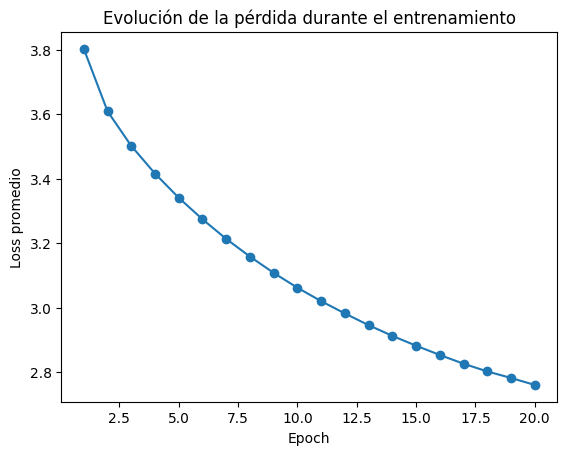

In [16]:
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
set_seed(42)

batch_size = 64
epochs = 20
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

losses = []

def sample_stanza(model, idx_to_token, token_to_idx, word2label, label_map, scheme='AABB', lines=4, max_words=10, temp=1.0, topk=50):
    model.eval()
    stanza = []
    scheme = scheme.upper()
    mapping = {c: l for c, l in zip(scheme, list(label_map.values())[:len(set(scheme))])}
    for l in range(lines):
        scheme_char = scheme[l % len(scheme)]
        target_label = mapping.get(scheme_char, None)
        line_tokens = ['<s>']
        hidden = None
        for wi in range(max_words):
            input_idx = torch.tensor([[token_to_idx.get(line_tokens[-1], token_to_idx['<unk>'])]], dtype=torch.long).to(device)
            logits, hidden = model(input_idx, hidden)
            logits = logits[0, -1, :].detach()
            probs = torch.softmax(logits / max(1e-8, temp), dim=-1).cpu().numpy()
            if wi == max_words - 1 and target_label is not None:
                # Constrained sampling para la última palabra
                candidates = [i for i, w in idx_to_token.items() if word2label.get(w) == target_label]
                if candidates:
                    cand_probs = probs[candidates]
                    s = cand_probs.sum()
                    if s > 0:
                        cand_probs = cand_probs / s
                        chosen = np.random.choice(candidates, p=cand_probs)
                    else:
                        chosen = np.random.choice(np.arange(len(probs)), p=probs/probs.sum())
                else:
                    chosen = np.random.choice(np.arange(len(probs)), p=probs/probs.sum())
            else:
                # top-k sampling
                idx = np.argpartition(-probs, topk-1)[:topk]
                p = probs[idx]
                p = p / p.sum()
                chosen = np.random.choice(idx, p=p)
            w = idx_to_token.get(int(chosen), '<unk>')
            if w == '</s>':
                break
            line_tokens.append(w)
        if line_tokens and line_tokens[0] == '<s>':
            line_tokens = line_tokens[1:]
        stanza.append(' '.join(line_tokens))
    return '\n'.join(stanza)

for epoch in range(1, epochs+1):
    model.train()
    total_loss = 0.0
    n_batches = 0
    for batch in tqdm(loader, desc=f'Epoch {epoch}'):
        batch = batch.to(device)
        inputs = batch[:, :-1]
        targets = batch[:, 1:]
        optimizer.zero_grad()
        logits, _ = model(inputs)
        loss = criterion(logits.view(-1, logits.size(-1)), targets.reshape(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        n_batches += 1
    avg_loss = total_loss / max(1, n_batches)
    losses.append(avg_loss)
    print(f'Epoch {epoch} - Loss promedio: {avg_loss:.4f}')
    # Generar ejemplo de estrofa
    print('\nEjemplo de estrofa generada (AABB):')
    print(sample_stanza(model, idx_to_token, token_to_idx, word2label, label_map, scheme='AABB', lines=4, max_words=10))
    print('-'*40)

plt.plot(range(1, len(losses)+1), losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss promedio')
plt.title('Evolución de la pérdida durante el entrenamiento')
plt.show()


## 8. Generación de muestras finales con rima forzada

**Explicación técnica:**
- Se puede elegir el esquema de rima (AABB, ABAB, etc), número de estrofas y versos por estrofa.
- Se fuerza la rima en la última palabra de cada verso según el esquema.
- Se pueden ajustar temperatura y top-k para controlar la creatividad.


In [17]:
# Parámetros de generación
num_stanzas = 10
lines_per_stanza = 4
scheme = 'AABB'
max_words_gen = 10
temp = 0.8  # Recomendado: menor para menos aleatoriedad
topk = 30   # Recomendado: menor para menos <unk>

all_samples = []
for s in range(num_stanzas):
    stanza = sample_stanza(model, idx_to_token, token_to_idx, word2label, label_map, scheme=scheme, lines=lines_per_stanza, max_words=max_words_gen, temp=temp, topk=topk)
    all_samples.append(stanza)

samples_text = f"# Generación final\n\nEsquema: {scheme}\nEstrofas: {num_stanzas}\nVersos por estrofa: {lines_per_stanza}\n\n"
samples_text += '\n\n'.join(all_samples)

print(samples_text)

# Guardar a archivo
with open('samples.txt', 'w', encoding='utf-8') as f:
    f.write(samples_text)
print('Muestras guardadas en samples.txt')


# Generación final

Esquema: AABB
Estrofas: 10
Versos por estrofa: 4

y del mundo y de su <unk>
el viento entre las piedras, las hojas,
<unk> <unk>
con <unk> <unk>

y <unk> el aire y el campo,
que te <unk> a curar en una tarde
<unk> de noche <unk>
la <unk>

y <unk> de <unk>
y el ruido de la noche
y en el <unk>
y de <unk>

que la noche <unk>
y se hace memoria.
por no <unk> <unk>
que me <unk> a ti, ¡dulce amor <unk>

que se <unk> en la frialdad de su <unk> escucha,
y el <unk> no temas, <unk> o <unk>
que me voy enredando en esas algas firmes
<unk> una silla,

y <unk> de <unk>
<unk> <unk> el <unk>
de algún modo soy la sombra todo <unk>
el último beso!

<unk> el <unk>
de los <unk>
en la tierra
que se <unk> en el ignorado del <unk>

<unk> la mano en la mejilla, medita grandes
ni <unk> <unk> en el <unk>
en una <unk> <unk>
y <unk> como fuman los condenados a muerte.

de <unk> y de <unk>
<unk> las <unk>
para el <unk> es de una <unk> a veces, que
al fin, a la puerta del <unk>

con una <unk> inst